In [3]:
import sys
# sys.path.append("../../PathPlanning/CubicSpline/")

import numpy as np
import math
import cvxpy
import matplotlib.pyplot as plt
import cubic_spline_planner
import joblib


In [174]:
NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
T = 5  # horizon length

# mpc parameters
R = np.diag([0.01, 0.01])  # input cost matrix
Rd = np.diag([0.01, 1.0])  # input difference cost matrix
Q = np.diag([1.0, 1.0, 0.5, 0.5])  # state cost matrix
Qf = Q  # state final matrix
GOAL_DIS = .15  # goal distance
STOP_SPEED = 0.5 / 3.6  # stop speed
MAX_TIME = 500.0  # max simulation time

# iterative paramter
MAX_ITER = 3  # Max iteration
DU_TH = 0.1  # iteration finish param

TARGET_SPEED = 10.0 / 3.6  # [m/s] target speed
N_IND_SEARCH = 10  # Search index number

DT = 0.2  # [s] time tick

# Vehicle parameters
LENGTH = 0.365  # [m]
WIDTH = 0.19  # [m]
BACKTOWHEEL = 0.1  # [m]
WHEEL_LEN = 0.03  # [m]
WHEEL_WIDTH = 0.02  # [m]
TREAD = 0.07  # [m]
WB = 0.26  # [m]

MAX_STEER = math.radians(21.0)  # maximum steering angle [rad]
MAX_DSTEER = math.radians(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 0.3  # maximum speed [m/s]
MIN_SPEED = -0.3  # minimum speed [m/s]
MAX_ACCEL = 0.01  # maximum accel [m/ss]

In [175]:

class State:
    """
    vehicle state class
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.predelta = None


def pi_2_pi(angle):
    while(angle > math.pi):
        angle = angle - 2.0 * math.pi

    while(angle < -math.pi):
        angle = angle + 2.0 * math.pi

    return angle


In [176]:
def get_linear_model_matrix(v, phi, delta):

    A = np.matrix(np.zeros((NX, NX)))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = DT * math.cos(phi)
    A[0, 3] = - DT * v * math.sin(phi)
    A[1, 2] = DT * math.sin(phi)
    A[1, 3] = DT * v * math.cos(phi)
    A[3, 2] = DT * math.tan(delta) / WB

    B = np.matrix(np.zeros((NX, NU)))
    B[2, 0] = DT
    B[3, 1] = DT * v / (WB * math.cos(delta) ** 2)

    C = np.zeros(NX)
    C[0] = DT * v * math.sin(phi) * phi
    C[1] = - DT * v * math.cos(phi) * phi
    C[3] = v * delta / (WB * math.cos(delta) ** 2)

    return A, B, C

In [177]:
def plot_car(x, y, yaw, steer=0.0, cabcolor="-r", truckcolor="-k"):

    outline = np.matrix([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                         [WIDTH / 2, WIDTH / 2, - WIDTH / 2, -WIDTH / 2, WIDTH / 2]])

    fr_wheel = np.matrix([[WHEEL_LEN, -WHEEL_LEN, -WHEEL_LEN, WHEEL_LEN, WHEEL_LEN],
                          [-WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD]])

    rr_wheel = np.copy(fr_wheel)

    fl_wheel = np.copy(fr_wheel)
    fl_wheel[1, :] *= -1
    rl_wheel = np.copy(rr_wheel)
    rl_wheel[1, :] *= -1

    Rot1 = np.matrix([[math.cos(yaw), math.sin(yaw)],
                      [-math.sin(yaw), math.cos(yaw)]])
    Rot2 = np.matrix([[math.cos(steer), math.sin(steer)],
                      [-math.sin(steer), math.cos(steer)]])

    fr_wheel = (fr_wheel.T * Rot2).T
    fl_wheel = (fl_wheel.T * Rot2).T
    fr_wheel[0, :] += WB
    fl_wheel[0, :] += WB

    fr_wheel = (fr_wheel.T * Rot1).T
    fl_wheel = (fl_wheel.T * Rot1).T

    outline = (outline.T * Rot1).T
    rr_wheel = (rr_wheel.T * Rot1).T
    rl_wheel = (rl_wheel.T * Rot1).T

    outline[0, :] += x
    outline[1, :] += y
    fr_wheel[0, :] += x
    fr_wheel[1, :] += y
    rr_wheel[0, :] += x
    rr_wheel[1, :] += y
    fl_wheel[0, :] += x
    fl_wheel[1, :] += y
    rl_wheel[0, :] += x
    rl_wheel[1, :] += y

    plt.plot(np.array(outline[0, :]).flatten(),
             np.array(outline[1, :]).flatten(), truckcolor)
    plt.plot(np.array(fr_wheel[0, :]).flatten(),
             np.array(fr_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(rr_wheel[0, :]).flatten(),
             np.array(rr_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(fl_wheel[0, :]).flatten(),
             np.array(fl_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(rl_wheel[0, :]).flatten(),
             np.array(rl_wheel[1, :]).flatten(), truckcolor)
    plt.plot(x, y, "*")


def update_state(state, a, delta):

    # input check
    if delta >= MAX_STEER:
        delta = MAX_STEER
    elif delta <= -MAX_STEER:
        delta = -MAX_STEER

    state.x = state.x + state.v * math.cos(state.yaw) * DT
    state.y = state.y + state.v * math.sin(state.yaw) * DT
    state.yaw = state.yaw + state.v / WB * math.tan(delta) * DT
    state.v = state.v + a * DT

    if state. v > MAX_SPEED:
        state.v = MAX_SPEED
    elif state. v < MIN_SPEED:
        state.v = MIN_SPEED

    return state


def get_nparray_from_matrix(x):
    return np.array(x).flatten()


def calc_nearest_index(state, cx, cy, cyaw, pind):

    dx = [state.x - icx for icx in cx[pind:(pind + N_IND_SEARCH)]]
    dy = [state.y - icy for icy in cy[pind:(pind + N_IND_SEARCH)]]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind) + pind

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


In [178]:

def predict_motion(x0, oa, od, xref):
    xbar = xref * 0.0
    for i in range(len(x0)):
        xbar[i, 0] = x0[i]

    state = State(x=x0[0], y=x0[1], yaw=x0[3], v=x0[2])
    for (ai, di, i) in zip(oa, od, range(1, T + 1)):
        state = update_state(state, ai, di)
        xbar[0, i] = state.x
        xbar[1, i] = state.y
        xbar[2, i] = state.v
        xbar[3, i] = state.yaw

    return xbar


def iterative_linear_mpc_control(xref, x0, dref, oa, od):
    """
    MPC contorl with updating operational point iteraitvely
    """

    if oa is None or od is None:
        oa = [0.0] * T
        od = [0.0] * T

    for i in range(MAX_ITER):
        xbar = predict_motion(x0, oa, od, xref)
        poa, pod = oa[:], od[:]
        oa, od, ox, oy, oyaw, ov = linear_mpc_control(xref, xbar, x0, dref)
        du = sum(abs(oa - poa)) + sum(abs(od - pod))  # calc u change value
        if du <= DU_TH:
            break
    else:
        print("Iterative is max iter")

    return oa, od, ox, oy, oyaw, ov


def linear_mpc_control(xref, xbar, x0, dref):
    """
    linear mpc control

    xref: reference point
    xbar: operational point
    x0: initial state
    dref: reference steer angle
    """

    x = cvxpy.Variable((NX, T + 1))
    u = cvxpy.Variable((NU, T))

    cost = 0.0
    constraints = []

    for t in range(T):
        cost += cvxpy.quad_form(u[:, t], R)

        if t != 0:
            cost += cvxpy.quad_form(xref[:, t] - x[:, t], Q)

        A, B, C = get_linear_model_matrix(
            xbar[2, t], xbar[3, t], dref[0, t])
        constraints += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t] + C]

        if t < (T - 1):
            cost += cvxpy.quad_form(u[:, t + 1] - u[:, t], Rd)
            constraints += [cvxpy.abs(u[1, t + 1] - u[1, t])
                            <= MAX_DSTEER * DT]

    cost += cvxpy.quad_form(xref[:, T] - x[:, T], Qf)

    constraints += [x[:, 0] == x0]
    constraints += [x[2, :] <= MAX_SPEED]
    constraints += [x[2, :] >= MIN_SPEED]
    constraints += [cvxpy.abs(u[0, :]) <= MAX_ACCEL]
    constraints += [cvxpy.abs(u[1, :]) <= MAX_STEER]

    prob = cvxpy.Problem(cvxpy.Minimize(cost), constraints)
    prob.solve(solver=cvxpy.ECOS, verbose=False)

    if prob.status == cvxpy.OPTIMAL or prob.status == cvxpy.OPTIMAL_INACCURATE:
        ox = get_nparray_from_matrix(x.value[0, :])
        oy = get_nparray_from_matrix(x.value[1, :])
        ov = get_nparray_from_matrix(x.value[2, :])
        oyaw = get_nparray_from_matrix(x.value[3, :])
        oa = get_nparray_from_matrix(u.value[0, :])
        odelta = get_nparray_from_matrix(u.value[1, :])

    else:
        print("Error: Cannot solve mpc..")
        oa, odelta, ox, oy, oyaw, ov = None, None, None, None, None, None

    return oa, odelta, ox, oy, oyaw, ov


def calc_ref_trajectory(state, cx, cy, cyaw, ck, sp, dl, pind):
    xref = np.zeros((NX, T + 1))
    dref = np.zeros((1, T + 1))
    ncourse = len(cx)

    ind, _ = calc_nearest_index(state, cx, cy, cyaw, pind)

    if pind >= ind:
        ind = pind

    xref[0, 0] = cx[ind]
    xref[1, 0] = cy[ind]
    xref[2, 0] = sp[ind]
    xref[3, 0] = cyaw[ind]
    dref[0, 0] = 0.0  # steer operational point should be 0

    travel = 0.0

    for i in range(T + 1):
        travel += abs(state.v) * DT
        dind = int(round(travel / dl))

        if (ind + dind) < ncourse:
            xref[0, i] = cx[ind + dind]
            xref[1, i] = cy[ind + dind]
            xref[2, i] = sp[ind + dind]
            xref[3, i] = cyaw[ind + dind]
            dref[0, i] = 0.0
        else:
            xref[0, i] = cx[ncourse - 1]
            xref[1, i] = cy[ncourse - 1]
            xref[2, i] = sp[ncourse - 1]
            xref[3, i] = cyaw[ncourse - 1]
            dref[0, i] = 0.0

    return xref, ind, dref


def check_goal(state, goal, tind, nind):

    # check goal
    dx = state.x - goal[0]
    dy = state.y - goal[1]
    d = math.sqrt(dx ** 2 + dy ** 2)

    if (d <= GOAL_DIS):
        isgoal = True
    else:
        isgoal = False

    if abs(tind - nind) >= 5:
        isgoal = False

    if (abs(state.v) <= STOP_SPEED):
        isstop = True
    else:
        isstop = False

    if isgoal and isstop:
        return True

    return False



In [179]:
preplan=joblib.load("preplan.z")

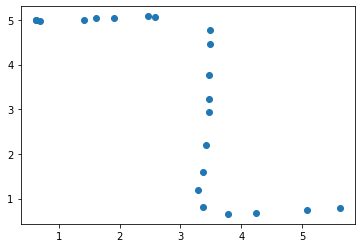

In [180]:
ax=preplan["x"][::10]
ay=preplan["y"][::10]

plt.scatter(ax,ay)

In [181]:
dl=0.02
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)

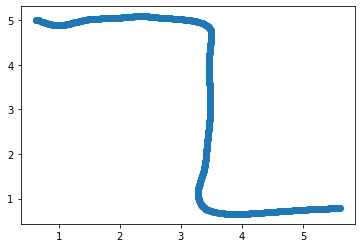

In [182]:
plt.scatter(cx,cy)

In [183]:
ax=[2196,1573,1164,1085,1125,1061,453,292,450,508,597,643]
ay=[200,191,261,880,1750,1976,1997,1998,1958,1924,1851,1854]

ax=[i*60/2331 for i in ax[-4:]]
ay=[i*60/2331 for i in ay[-4:]]

In [184]:
dl=0.2
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)

In [185]:
len(ax)

4

In [186]:
len(ay)

4

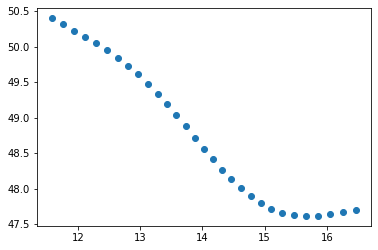

In [187]:
plt.scatter(cx,cy)

[0.8108108108108109, 0.9446589446589446, 1.2072072072072073, 1.3745173745173744, 1.546975546975547, 1.8018018018018018]
[5.117117117117117, 5.117117117117117, 5.057915057915058, 4.916344916344916, 4.787644787644788, 4.754182754182755]


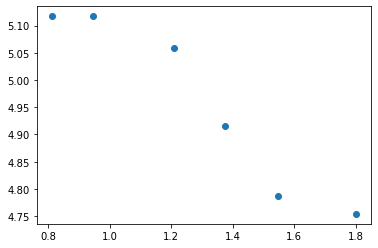

In [194]:
ax=[315,367,469,534,601,700]
ay=[1988,1988,1965,1910,1860,1847]


# ax.reverse()
# ay.reverse()

ax=[i*6/2331 for i in ax]
ay=[i*6/2331 for i in ay]

# ax=[0,5,10,15,15]
# ay=[10,5,0,-5,-10]
plt.scatter(ax,ay)
print(ax)
print(ay)
dl=0.05
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=dl)
# reverse yaw
cyaw = [i - math.pi for i in cyaw]

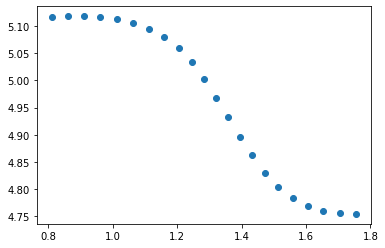

In [189]:
plt.scatter(cx,cy)

In [190]:
def do_simulation(cx, cy, cyaw, ck, sp, dl, initial_state):
    """
    Simulation

    cx: course x position list
    cy: course y position list
    cy: course yaw position list
    ck: course curvature list
    sp: speed profile
    dl: course tick [m]

    """

    goal = [cx[-1], cy[-1]]

    state = initial_state

    # initial yaw compensation
    if state.yaw - cyaw[0] >= math.pi:
        state.yaw -= math.pi * 2.0
    elif state.yaw - cyaw[0] <= -math.pi:
        state.yaw += math.pi * 2.0

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    d = [0.0]
    a = [0.0]
    target_ind, _ = calc_nearest_index(state, cx, cy, cyaw, 0)

    odelta, oa = None, None

    cyaw = smooth_yaw(cyaw)

    while MAX_TIME >= time:
        xref, target_ind, dref = calc_ref_trajectory(
            state, cx, cy, cyaw, ck, sp, dl, target_ind)

        x0 = [state.x, state.y, state.v, state.yaw]  # current state

        oa, odelta, ox, oy, oyaw, ov = iterative_linear_mpc_control(
            xref, x0, dref, oa, odelta)

        if odelta is not None:
            di, ai = odelta[0], oa[0]

        state = update_state(state, ai, di)
        time = time + DT

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)
        d.append(di)
        a.append(ai)

        if check_goal(state, goal, target_ind, len(cx)):
            print("Goal")
            break

        # if show_animation:
        #     plt.cla()
        #     if ox is not None:
        #         plt.plot(ox, oy, "xr", label="MPC")
        #     plt.plot(cx, cy, "-r", label="course")
        #     plt.plot(x, y, "ob", label="trajectory")
        #     plt.plot(xref[0, :], xref[1, :], "xk", label="xref")
        #     plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
        #     plot_car(state.x, state.y, state.yaw, steer=di)
        #     plt.axis("equal")
        #     plt.grid(True)
        #     plt.title("Time[s]:" + str(round(time, 2)) +
        #               ", speed[km/h]:" + str(round(state.v * 3.6, 2)))
        #     plt.pause(0.0001)

    return t, x, y, yaw, v, d, a


def calc_speed_profile(cx, cy, cyaw, target_speed):

    speed_profile = [target_speed] * len(cx)
    direction = 1.0  # forward

    # Set stop point
    for i in range(len(cx) - 1):
        dx = cx[i + 1] - cx[i]
        dy = cy[i + 1] - cy[i]

        move_direction = math.atan2(dy, dx)

        if dx != 0.0 and dy != 0.0:
            dangle = abs(pi_2_pi(move_direction - cyaw[i]))
            if dangle >= math.pi / 4.0:
                direction = -1.0
            else:
                direction = 1.0

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

    speed_profile[-1] = 0.0

    return speed_profile


def smooth_yaw(yaw):

    for i in range(len(yaw) - 1):
        dyaw = yaw[i + 1] - yaw[i]

        while dyaw >= math.pi / 2.0:
            yaw[i + 1] -= math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

        while dyaw <= -math.pi / 2.0:
            yaw[i + 1] += math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

    return yaw




In [191]:
sp = calc_speed_profile(cx, cy, cyaw, TARGET_SPEED)

initial_state = State(x=cx[0], y=cy[0], yaw=3.14, v=0.0)

t, x, y, yaw, v, d, a = do_simulation(
    cx, cy, cyaw, ck, sp, dl, initial_state)

Goal


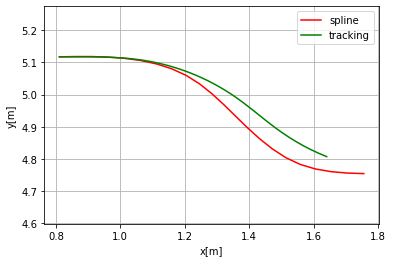

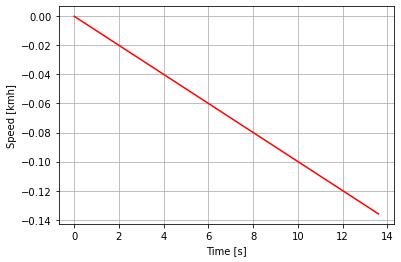

In [192]:
plt.close("all")
plt.subplots()
plt.plot(cx, cy, "-r", label="spline")
plt.plot(x, y, "-g", label="tracking")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()

plt.subplots()
plt.plot(t, v, "-r", label="speed")
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("Speed [kmh]")

plt.show()

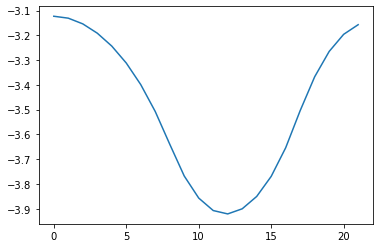

In [193]:
plt.plot(cyaw)